## Importing all necessary libraries

In [14]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import spacy
import contractions
import string
import re
from bs4 import BeautifulSoup
from unidecode import unidecode
import nltk
import swifter
from nltk.corpus import stopwords
from wordcloud import WordCloud

from transformers import AutoTokenizer
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv('IMDB Dataset.csv')

#### Preview of IMDB movie review dataset (First 10 rows) found here: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [16]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Data cleaning - preprocessing

In [17]:
df.isnull().sum() # Checking for empty (null) values in the dataset

# No null values

review       0
sentiment    0
dtype: int64

In [18]:
sentiments = df.sentiment.replace({1 : 'positive', 0 : 'negative'})

### Visualizing data


#### 1. Distribution of Sentiment values in a pie chart (positive - negative)

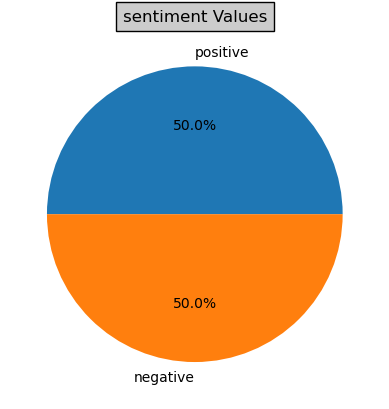

In [ ]:
sentiment_val = sentiments.value_counts().values
sentiment_in = sentiments.value_counts().index

g_pie = plt.pie(sentiment_val,labels=sentiment_in, autopct ='%1.1f%%')
plt.title("sentiment Values", bbox={'facecolor':'0.8', 'pad':5})

plt.show()

#### 2. Distribution in a bar chart

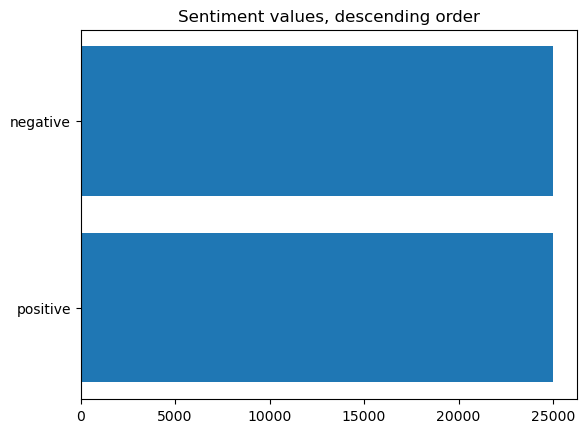

In [20]:
fig, ax = plt.subplots()

bar = ax.barh(sentiment_in, sentiment_val)
ax.set_title("Sentiment values, descending order")

plt.show()

### 3. Distribution of most used words present in the reviews with WordCloud

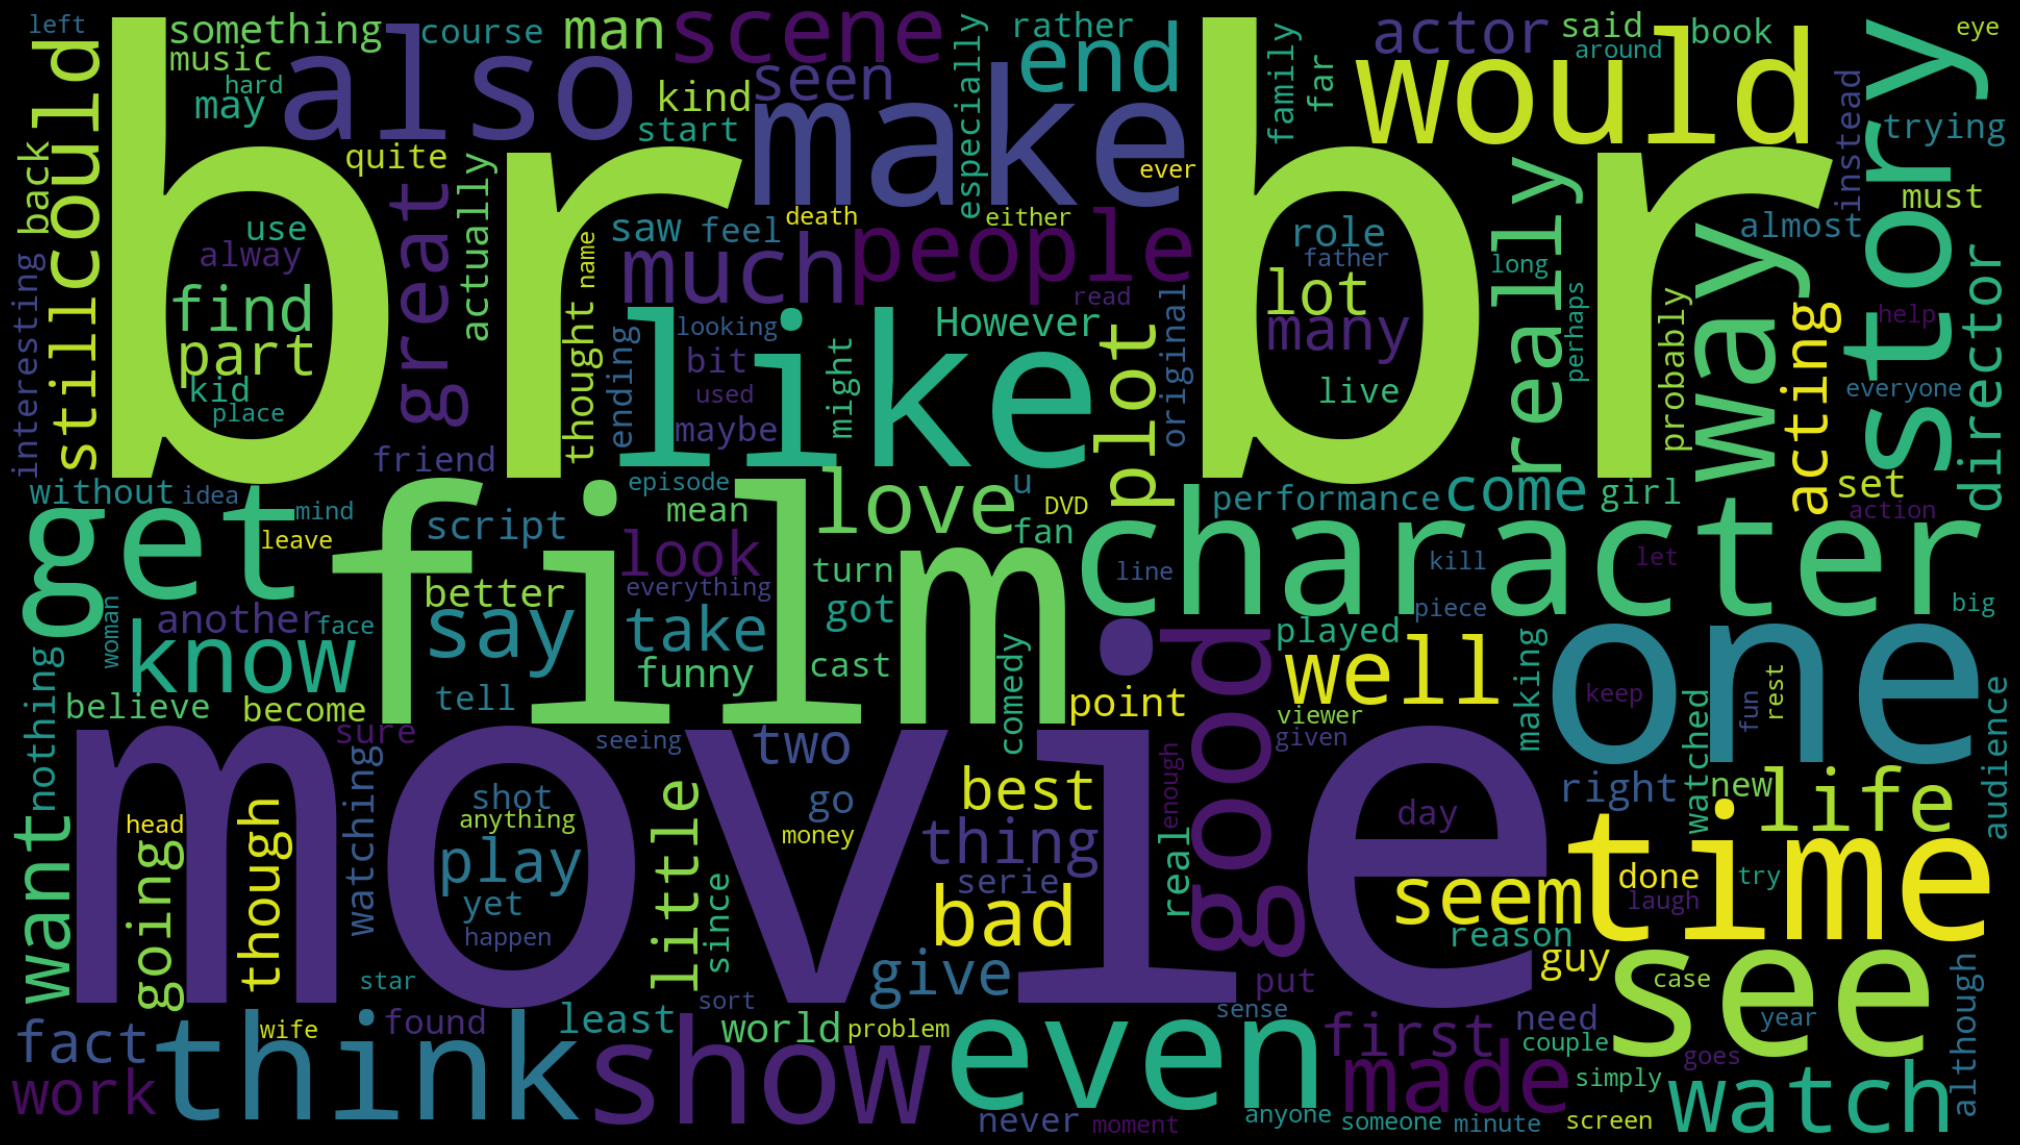

In [21]:
# Joining all rows together
text = ' '.join(map(str, df['review']))

wordcloud = WordCloud (width = 1920, height = 1080, stopwords= set(nltk.corpus.stopwords.words("english")), 
                       background_color = 'black').generate(text)

figure = plt.figure(figsize = (20,20), facecolor = "k", edgecolor = "k"
)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### It is clear that the popular words 'br' offer no meaning to the sentiment. In reality, <(br)> is used for html formatting, which was passed along with the text while the data was retrieved.
#### We will perform preprocessing to remove any such noise

In [22]:
# Unicode to ascii if exists for machine readability
def replace_foreign_chars(text):
    return unidecode(text)

df['review'] = df['review'].apply(replace_foreign_chars)


# Contractions handling (contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe, such as "you are" -> "you're" )
def expand_contractions(text):
    return contractions.fix(text)

# Replacing review column with expanded contractions
df['expanded_text'] = df['review'].apply(expand_contractions)
df.drop('review', axis=1, inplace=True)
df.rename(columns={'expanded_text': 'review'}, inplace=True)

#Remove html tags func
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    cleaned_text = soup.get_text()
    
    return cleaned_text

df['review'] = df['review'].apply(remove_html_tags)

#Convert text to lowercase text
def lowercase_text(text):
    return " ".join(x.lower() for x in text.split() )

df['review'] = df['review'].apply(lowercase_text)

#Remove URLs and special Characters
def remove_urls(text):
    cleaned_text = re.sub(r'http\S+', '', text)
    return cleaned_text

def remove_special_characters(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

df['review'] = df['review'].apply(remove_urls)
df['review'] = df['review'].apply(remove_special_characters)

#Delete numbers from dataset
df["review"] = df["review"].str.replace('\d','')



#Punctuations hadnling
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text_without_punctuation = text.translate(translator)
    return text_without_punctuation

df['review'] = df['review'].apply(remove_punctuation)



#Remove Stopwords and Punctuations
def remove_stopwords_punctuation(text):
    stop_words = set(stopwords.words("english"))
    punctuation = list(string.punctuation)
    stop_words.update(punctuation)
    filtered_text = " ".join(x for x in text.split() if x not in stop_words)
    return filtered_text

df["review"] = df["review"].apply(remove_stopwords_punctuation)

### Lemmatization is a process of stemming, used to convert all words to their root/original form

In [23]:
# Performing lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word)

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatize_word(word) for word in tokens]
    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text

df['review'] = df['review'].swifter.apply(lemmatize_text)

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

### Distributing words with WordCloud again to observe the actual popularity of the words in the processed and clean dataset

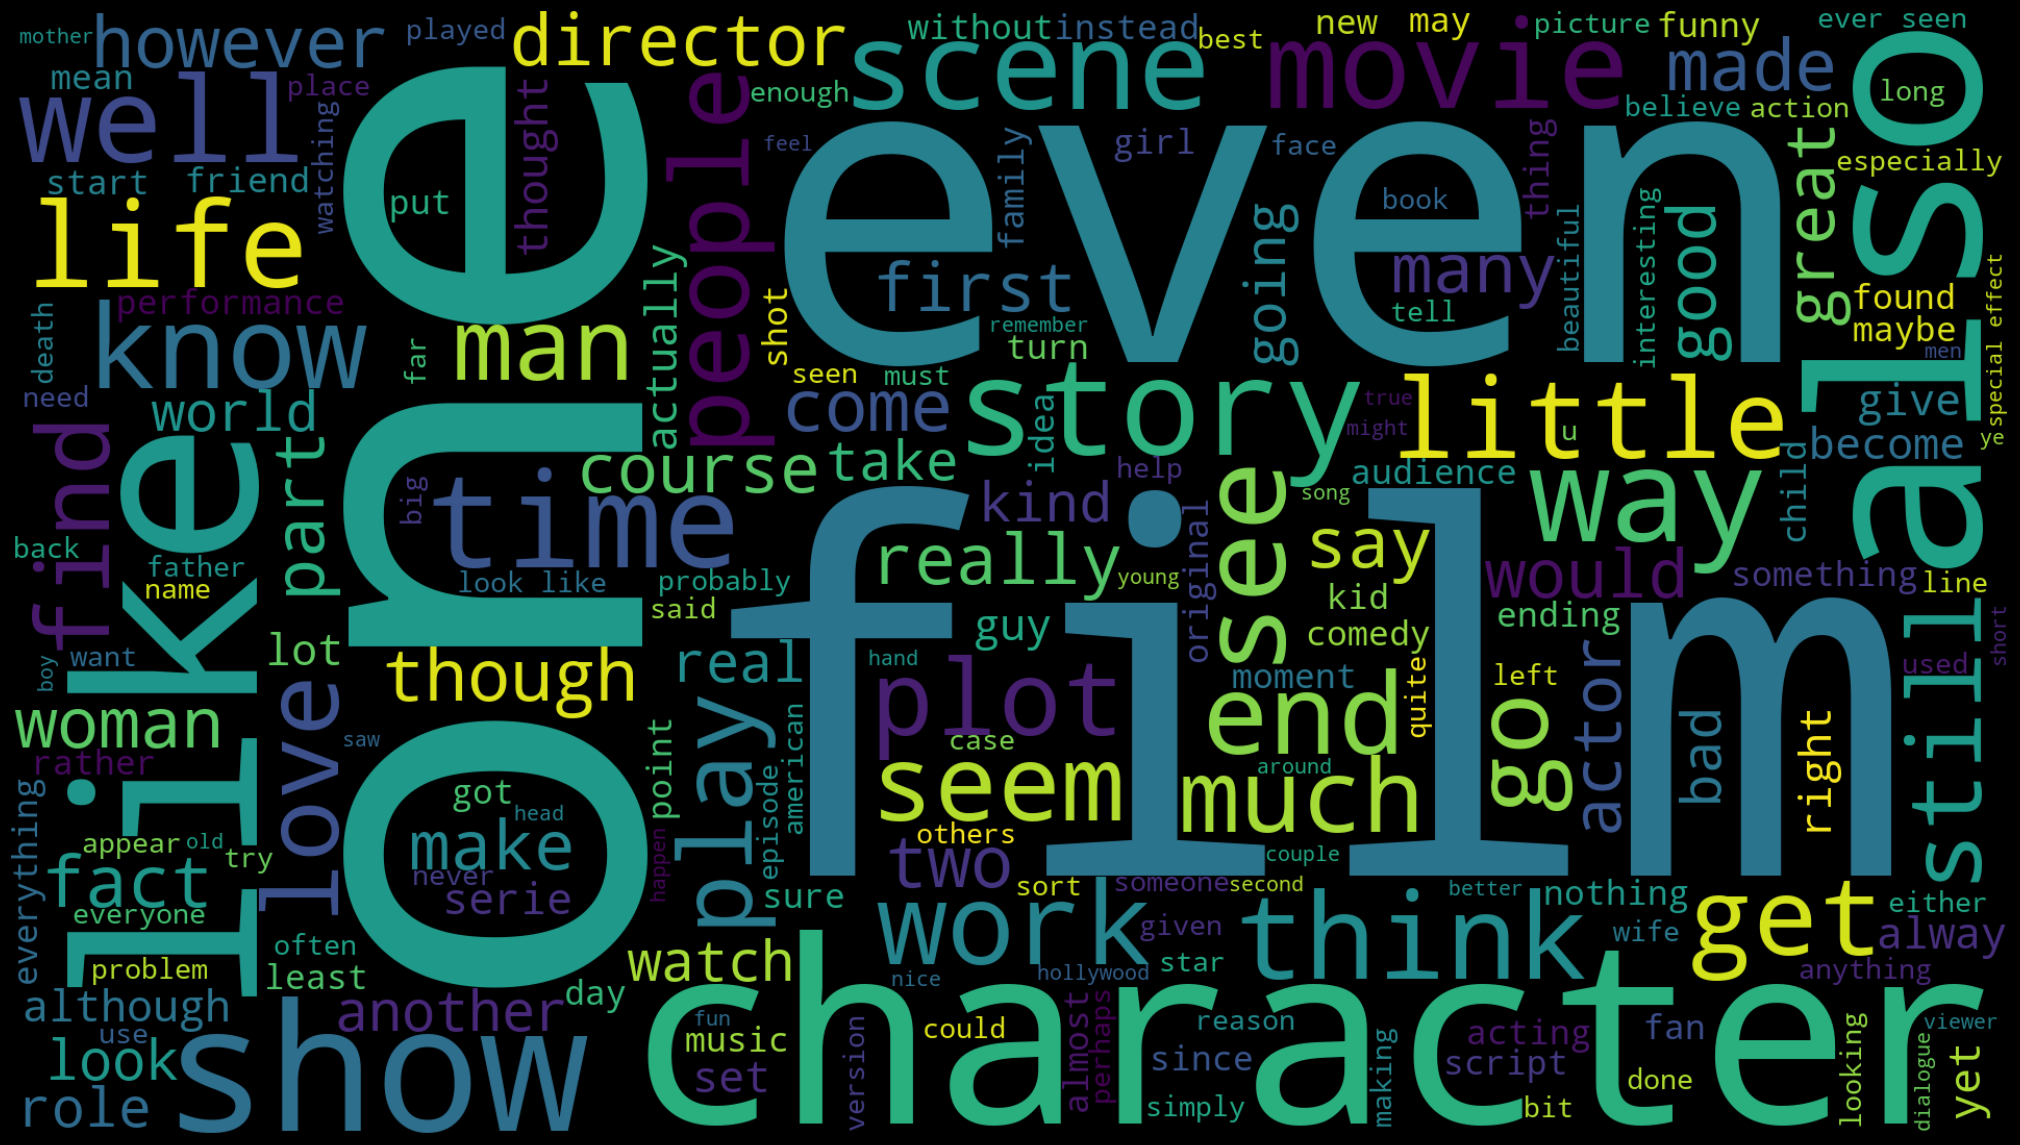

In [24]:
# Joining all rows together
text = ' '.join(map(str, df['review']))

wordcloud = WordCloud (width = 1920, height = 1080, stopwords= set(nltk.corpus.stopwords.words("english")), 
                       background_color = 'black').generate(text)

figure = plt.figure(figsize = (20,20), facecolor = "k", edgecolor = "k"
)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Sentiment Analysis with TextBlob

In [25]:
from textblob import TextBlob

In [26]:
df['polarity'] = df.review.apply(lambda x: TextBlob(x).polarity)
df['subjectivity'] = df.review.apply(lambda x: TextBlob(x).subjectivity)

df.head()

,sentiment,review,polarity,subjectivity
0,positive,one reviewer mentioned watching oz episode hoo...,0.023881,0.465048
1,positive,wonderful little production filming technique ...,0.127604,0.567708
2,positive,thought wonderful way spend time hot summer we...,0.264732,0.680357
3,negative,basically family little boy jake think zombie ...,-0.042188,0.522917
4,positive,petter matteis love time money visually stunni...,0.244901,0.425816


#### If polarity > 0, the text is classified as positive. 
#### If polarity < 0 , as negative. 
#### If polarity == 0, as neutral

In [27]:
def segment(x):
    if x > 0:
        return "positive"
    elif x < 0:
        return "negative"
    else:
        return "neutral"

df['TextBlob Sentiment'] = df['polarity'].apply(segment)
df.head(10)

,sentiment,review,polarity,subjectivity,TextBlob Sentiment
0,positive,one reviewer mentioned watching oz episode hoo...,0.023881,0.465048,positive
1,positive,wonderful little production filming technique ...,0.127604,0.567708,positive
2,positive,thought wonderful way spend time hot summer we...,0.264732,0.680357,positive
3,negative,basically family little boy jake think zombie ...,-0.042188,0.522917,negative
4,positive,petter matteis love time money visually stunni...,0.244901,0.425816,positive
5,positive,probably alltime favorite movie story selfless...,0.045455,0.551515,positive
6,positive,sure would like see resurrection dated seahunt...,0.258712,0.472096,positive
7,negative,show amazing fresh innovative idea first aired...,0.118561,0.624621,positive
8,negative,encouraged positive comment film looking forwa...,-0.217626,0.695253,negative
9,positive,like original gut wrenching laughter like movi...,0.335000,0.550000,positive


In [28]:
df['TextBlob Sentiment'].value_counts()

positive    36806
negative    13146
neutral        48
Name: TextBlob Sentiment, dtype: int64

#### Performing a classification report to observe the metrics of TextBlob's polarity sentiment analysis performance

In [29]:
actual_sentiment = df['sentiment']
predicted_sentiment = df['TextBlob Sentiment']
print(classification_report(actual_sentiment, predicted_sentiment))

              precision    recall  f1-score   support

    negative       0.88      0.46      0.60     25000
     neutral       0.00      0.00      0.00         0
    positive       0.63      0.93      0.76     25000

    accuracy                           0.70     50000
   macro avg       0.50      0.46      0.45     50000
weighted avg       0.76      0.70      0.68     50000



In [30]:
print('Accuracy on sentiments:', accuracy_score(predicted_sentiment, actual_sentiment))
# Precision, recall, f1 using macro average.
print('Precision on sentiments:', precision_score(predicted_sentiment, actual_sentiment, average='macro'))
print('Recall on sentiments:', recall_score(predicted_sentiment, actual_sentiment, average='macro'))
print('F1-Score sentiments:', f1_score(predicted_sentiment, actual_sentiment, average='macro'))

Accuracy on sentiments: 0.69726
Precision on sentiments: 0.46484
Recall on sentiments: 0.5034446120908618
F1-Score sentiments: 0.45309281669590734


### Plotting a confusion matrix, which counts the number of classifications and missclassifications for the predicted values matching the actual ones

[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Neutral'), Text(0, 2.5, 'Negative')]

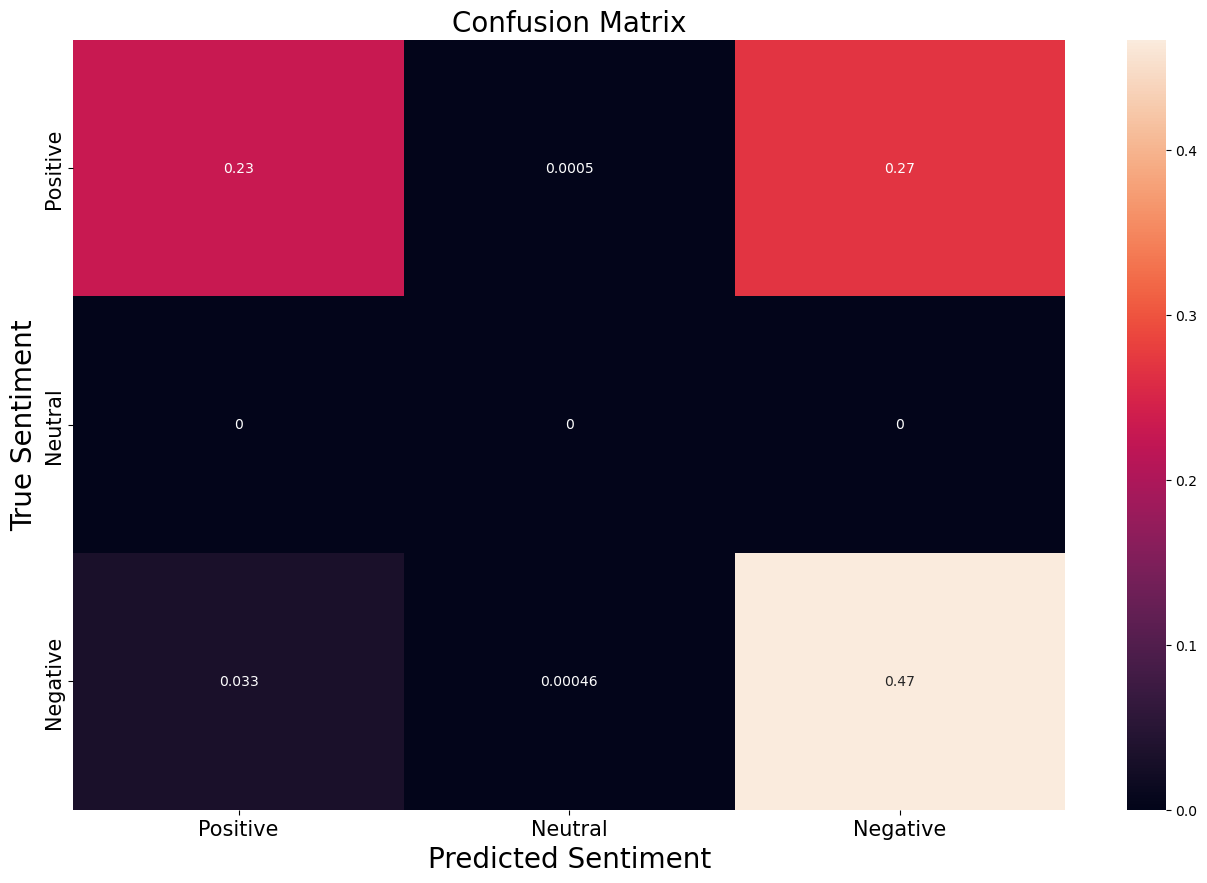

In [31]:
matrix = confusion_matrix(actual_sentiment, predicted_sentiment, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Sentiment', size=20)
ax.set_ylabel('True Sentiment', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(['Positive', 'Neutral', 'Negative'], size=15)
ax.yaxis.set_ticklabels(['Positive', 'Neutral', 'Negative'], size=15)

## Vader Sentiment Analysis

In [38]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a SentimentIntensityAnalyzer object.
model_vader = SentimentIntensityAnalyzer()

def vader_sentiment(review):
    # polarity_scores give a dictionary of sentiments containing pos, neg, neu, and compound scores.
    sentiment_dict = model_vader.polarity_scores(review)

    if sentiment_dict['compound'] >= 0.05:
        return("positive")
    elif sentiment_dict['compound'] <= -0.05:
        return("negative")
    else:
        return("neutral")

df['Vader Sentiment'] = df['review'].apply(vader_sentiment)
df.head(10)


,sentiment,review,polarity,subjectivity,TextBlob Sentiment,Vader Sentiment
0,positive,one reviewer mentioned watching oz episode hoo...,0.023881,0.465048,positive,negative
1,positive,wonderful little production filming technique ...,0.127604,0.567708,positive,positive
2,positive,thought wonderful way spend time hot summer we...,0.264732,0.680357,positive,positive
3,negative,basically family little boy jake think zombie ...,-0.042188,0.522917,negative,negative
4,positive,petter matteis love time money visually stunni...,0.244901,0.425816,positive,positive
5,positive,probably alltime favorite movie story selfless...,0.045455,0.551515,positive,positive
6,positive,sure would like see resurrection dated seahunt...,0.258712,0.472096,positive,positive
7,negative,show amazing fresh innovative idea first aired...,0.118561,0.624621,positive,positive
8,negative,encouraged positive comment film looking forwa...,-0.217626,0.695253,negative,negative
9,positive,like original gut wrenching laughter like movi...,0.335000,0.550000,positive,positive


In [39]:
df['Vader Sentiment'].value_counts()

positive    34739
negative    14717
neutral       544
Name: Vader Sentiment, dtype: int64

In [40]:
actual_sentiment = df['sentiment']
predicted_sentiment = df['Vader Sentiment']
print(classification_report(actual_sentiment, predicted_sentiment))

              precision    recall  f1-score   support

    negative       0.79      0.47      0.59     25000
     neutral       0.00      0.00      0.00         0
    positive       0.63      0.87      0.73     25000

    accuracy                           0.67     50000
   macro avg       0.47      0.45      0.44     50000
weighted avg       0.71      0.67      0.66     50000



In [41]:
print('Accuracy on sentiments:', accuracy_score(predicted_sentiment, actual_sentiment))
# Precision, recall, f1 using macro average.
print('Precision on sentiments:', precision_score(predicted_sentiment, actual_sentiment, average='macro'))
print('Recall on sentiments:', recall_score(predicted_sentiment, actual_sentiment, average='macro'))
print('F1-Score sentiments:', f1_score(predicted_sentiment, actual_sentiment, average='macro'))

Accuracy on sentiments: 0.66836
Precision on sentiments: 0.4455733333333334
Recall on sentiments: 0.47271294782699114
F1-Score sentiments: 0.43846231606856173


[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Neutral'), Text(0, 2.5, 'Negative')]

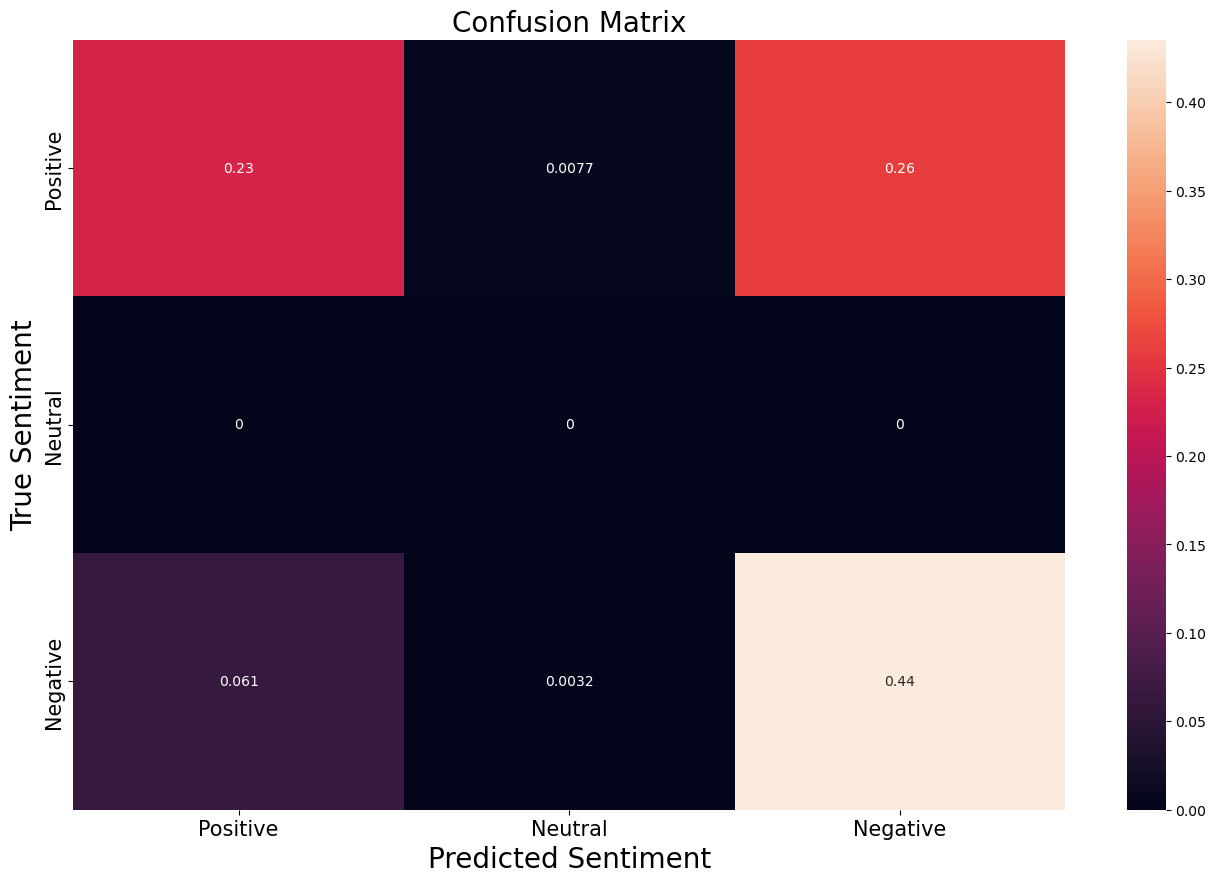

In [42]:
matrix = confusion_matrix(actual_sentiment, predicted_sentiment, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Sentiment', size=20)
ax.set_ylabel('True Sentiment', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(['Positive', 'Neutral', 'Negative'], size=15)
ax.yaxis.set_ticklabels(['Positive', 'Neutral', 'Negative'], size=15)

### As we can see, the TextBlob Analysis performed slightly better than Vader Analysis